In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Reshape
from tensorflow.keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np

In [10]:
class PDESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        #batch_size=tf.shape(data)[0]
        batch_size=10
        t = tf.random.uniform((batch_size,1), minval=0, maxval=1)#1.1
        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                with tf.GradientTape() as gg:
                    gg.watch(x)
                    input = tf.concat((x,t),axis=1)
                    y_pred = self(input, training=True)
                y_x=gg.gradient(y_pred,x)
            y_xx=g.gradient(y_x,x)
            
            t_init = tf.random.uniform((batch_size,1), minval=0, maxval=0.1)
            x_o = tf.zeros((batch_size, 1))
            input_o = tf.concat((x_o, t_init),axis=1)
            y_o = self(input_o, training=True)
            eq = y_xx + y_pred
            ci1 = 1.0
            ci2 = -0.5
            
            input_ini = tf.concat((x,t_init),axis=1)
            y_init = self(input_ini, training=True)
            loss = self.mse(0., eq) + self.mse(y_0,ci1)+ self.mse(x_o,ci2)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [11]:
model = PDESolver()
model.add(Dense(100, activation='tanh', input_shape=(2,), name="primera"))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))
#model.add(Reshape(()))
model.summary()

Model: "pde_solver_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 100)               300       
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1321 (5.16 KB)
Trainable params: 1321 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(optimizer="adam")

In [14]:
batch_size=10
x = tf.random.uniform((10,1), minval=-5, maxval=5)
t_init = tf.random.uniform((batch_size,1), minval=0, maxval=0.1)

input_o = tf.concat((x,t_init),axis=1)
history = model.fit(input_o,epochs=500,verbose=0)
plt.plot(history.history["loss"])

NameError: in user code:

    File "C:\Users\el_he\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\el_he\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\el_he\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\el_he\AppData\Local\Temp\ipykernel_6512\438213211.py", line 37, in train_step
        loss = self.mse(0., eq) + self.mse(y_0,ci1)+ self.mse(x_o,ci2)

    NameError: name 'y_0' is not defined


El siguiente codigo ya jaló (mejor intento con la pérdida, pero sigue sin ser buena aproximación).

Model: "pde_solver_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 100)               300       
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1321 (5.16 KB)
Trainable params: 1321 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


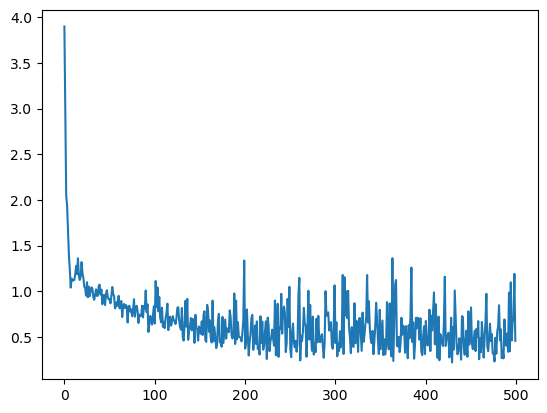

In [15]:
class PDESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        batch_size=10
        t = tf.random.uniform((batch_size,1), minval=0, maxval=1)
        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                with tf.GradientTape() as gg:
                    gg.watch(x)
                    input = tf.concat((x,t),axis=1)
                    y_pred = self(input, training=True)
                y_x=gg.gradient(y_pred,x)
            y_xx=g.gradient(y_x,x)
            
            t_init = tf.random.uniform((batch_size,1), minval=0, maxval=0.1)
            x_o = tf.zeros((batch_size, 1))
            input_o = tf.concat((x_o,t_init),axis=1)
            y_o = self(input_o, training=True)
            eq = y_xx - y_pred
            ci1 = 1.0
            ci2 = -0.5
            
            input_ini = tf.concat((x,t_init),axis=1)
            y_init = self(input_ini, training=True)
            loss = self.mse(0., eq) + self.mse(y_o,ci1)+ self.mse(y_init,ci2)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = PDESolver()
model.add(Dense(100, activation='tanh', input_shape=(2,), name="primera"))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.summary()
model.compile(optimizer="adam")
batch_size=10
x = tf.random.uniform((10,1), minval=-5, maxval=5)
t_init = tf.random.uniform((batch_size,1), minval=0, maxval=0.1)

input_o = tf.concat((x,t_init),axis=1)

# Aquí es donde se define y_o fuera del bloque with tf.GradientTape() as tape:
y_o = model(input_o)

history = model.fit(input_o,y_o ,epochs=500,verbose=0)
plt.plot(history.history["loss"])


16/16 [==============================] - 0s 2ms/step


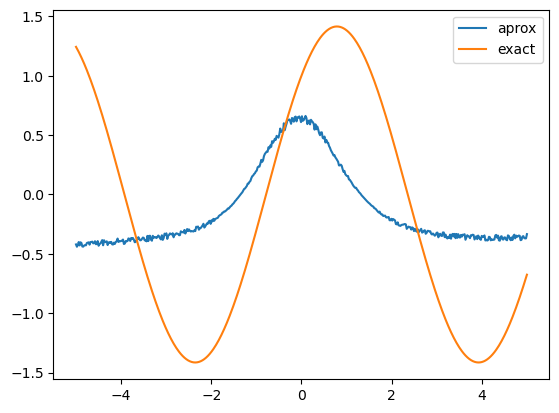

In [19]:
x_testv = tf.linspace(-5,5,500)
x_testv = tf.cast(x_testv, dtype=tf.float32)
x_testv = tf.reshape(x_testv, (-1, 1)) # Asegúrate de que x_testv tiene la forma correcta
t_init = tf.random.uniform((500,1), minval=0, maxval=0.1) # Genera un tensor de tiempo aleatorio
t_init = tf.cast(t_init, dtype=tf.float32)

input_o = tf.concat((x_testv,t_init),axis=1) # Concatena x_testv y t_init

a=model.predict(input_o) # Realiza la predicción con el modelo

plt.plot(x_testv,a,label="aprox") # Grafica la predicción del modelo
plt.plot(x_testv,tf.sin(x_testv) + tf.cos(x_testv),label="exact") # Grafica la solución exacta
plt.legend()
plt.show()



Pruebas para la segunda corrida con mas epocas y con Learning rate, ademsa de cambiar las capas


Model: "pde_solver_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 primera (Dense)             (None, 100)               300       
                                                                 
 dense_12 (Dense)            (None, 10)                1010      
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1321 (5.16 KB)
Trainable params: 1321 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


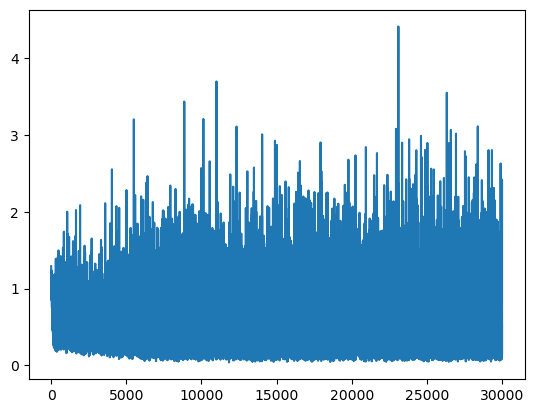

In [26]:
class PDESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        batch_size=10
        t = tf.random.uniform((batch_size,1), minval=0, maxval=1)
        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                with tf.GradientTape() as gg:
                    gg.watch(x)
                    input = tf.concat((x,t),axis=1)
                    y_pred = self(input, training=True)
                y_x=gg.gradient(y_pred,x)
            y_xx=g.gradient(y_x,x)
            
            t_init = tf.random.uniform((batch_size,1), minval=0, maxval=0.1)
            x_o = tf.zeros((batch_size, 1))
            input_o = tf.concat((x_o,t_init),axis=1)
            y_o = self(input_o, training=True)
            eq = y_xx - y_pred
            ci1 = 1.0
            ci2 = -0.5
            
            input_ini = tf.concat((x,t_init),axis=1)
            y_init = self(input_ini, training=True)
            loss = self.mse(0., eq) + self.mse(y_o,ci1)+ self.mse(y_init,ci2)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = PDESolver()
model.add(Dense(100, activation='tanh', input_shape=(2,), name="primera"))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='linear'))
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001))
batch_size=10
x = tf.random.uniform((10,1), minval=-5, maxval=5)
t_init = tf.random.uniform((batch_size,1), minval=0, maxval=0.1)

input_o = tf.concat((x,t_init),axis=1)

# Aquí es donde se define y_o fuera del bloque with tf.GradientTape() as tape:
y_o = model(input_o)

history = model.fit(input_o,y_o ,epochs=30000,verbose=0)
plt.plot(history.history["loss"])


32/32 [==============================] - 0s 2ms/step


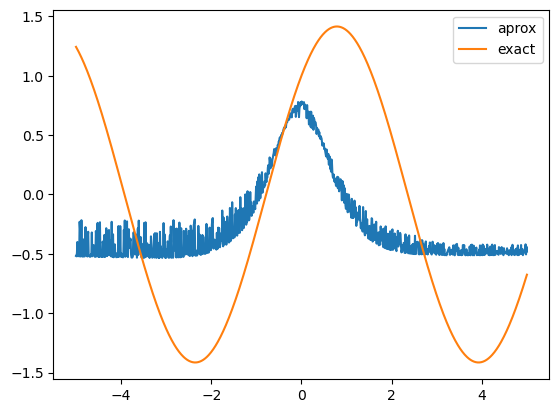

In [27]:
x_testv = tf.linspace(-5,5,1000)
x_testv = tf.cast(x_testv, dtype=tf.float32)
x_testv = tf.reshape(x_testv, (-1, 1)) # Asegúrate de que x_testv tiene la forma correcta
t_init = tf.random.uniform((1000,1), minval=0, maxval=0.1) # Genera un tensor de tiempo aleatorio
t_init = tf.cast(t_init, dtype=tf.float32)

input_o = tf.concat((x_testv,t_init),axis=1) # Concatena x_testv y t_init

a=model.predict(input_o) # Realiza la predicción con el modelo

plt.plot(x_testv,a,label="aprox") # Grafica la predicción del modelo
plt.plot(x_testv,tf.sin(x_testv) + tf.cos(x_testv),label="exact") # Grafica la solución exacta
plt.legend()
plt.show()


Nuevos cambios en las capas y el optimizador.

In [ ]:
class PDESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
        batch_size=10
        t = tf.random.uniform((batch_size,1), minval=0, maxval=1)
        x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)

        with tf.GradientTape() as tape:
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                with tf.GradientTape() as gg:
                    gg.watch(x)
                    input = tf.concat((x,t),axis=1)
                    y_pred = self(input, training=True)
                y_x=gg.gradient(y_pred,x)
            y_xx=g.gradient(y_x,x)
            
            t_init = tf.random.uniform((batch_size,1), minval=0, maxval=0.1)
            x_o = tf.zeros((batch_size, 1))
            input_o = tf.concat((x_o,t_init),axis=1)
            y_o = self(input_o, training=True)
            eq = y_xx - y_pred
            ci1 = 1.0
            ci2 = -0.5
            
            input_ini = tf.concat((x,t_init),axis=1)
            y_init = self(input_ini, training=True)
            loss = self.mse(0., eq) + self.mse(y_o,ci1)+ self.mse(y_init,ci2)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = PDESolver()
model.add(Dense(300, activation='tanh', input_shape=(2,), name="primera"))
model.add(Dense(100, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer="adam")
batch_size=10
x = tf.random.uniform((10,1), minval=-5, maxval=5)
t_init = tf.random.uniform((batch_size,1), minval=0, maxval=0.1)

input_o = tf.concat((x,t_init),axis=1)

# Aquí es donde se define y_o fuera del bloque with tf.GradientTape() as tape:
y_o = model(input_o)

history = model.fit(input_o,y_o ,epochs=500,verbose=0)
plt.plot(history.history["loss"])